# Game of Thrones End-To-End Notebook

This notebook contains an end-to-end workflow using multiple csv files of Game of Thrones battle data.

In [1]:
import os
from neo4j_runway.utils.data import load_data_dictionary_from_yaml, load_local_files
from neo4j_runway.llm.openai import OpenAIDataModelingLLM, OpenAIDiscoveryLLM
from neo4j_runway.discovery import Discovery
from neo4j_runway import GraphDataModeler
from neo4j_runway.code_generation import PyIngestConfigGenerator
from neo4j_runway.ingestion import PyIngest

## Read Data

In [2]:
data_dictionary = load_data_dictionary_from_yaml("data_dictionary.yaml")
data_dictionary

{'got_armies.csv': {'battle_number': 'A unique ID for the battle.',
  'king': 'A king participating in the battle.',
  'outcome': 'Whether the battle was won or lost.',
  'family': 'A significant family in the battle.',
  'size': 'The size of the army.',
  'commander': 'The commander leading an army in the battle.',
  'attacking': 'Whether the army is attacking or not.'},
 'got_battles.csv': {'name': 'The name of the battle.',
  'year': 'The year the battle took place.',
  'battle_number': 'A unique ID for the battle.',
  'summer': 'Whether the battle took place during Summer.',
  'location': 'The location of the battle.',
  'region': 'The larger region a battle took place in.'}}

In [3]:
data_directory = "../../../data/got/multi/"
data = load_local_files(data_directory=data_directory, 
                        general_description="This file contains data on game of thrones battles", 
                        data_dictionary=data_dictionary, 
                        use_cases=["What families have changed alliances?", 
                                   "how have army sizes changed over time?", 
                                   "Which families attack most often?"],
                        )

In [6]:
data.tables[0].dataframe.head()

,battle_number,king,outcome,family,size,commander,attacking
0,1,Joffrey/Tommen Baratheon,True,Lannister,15000.0,Jaime Lannister,True
1,2,Joffrey/Tommen Baratheon,True,Lannister,NaN,Gregor Clegane,True
2,3,Joffrey/Tommen Baratheon,True,Lannister,15000.0,Jaime Lannister,True
3,3,Joffrey/Tommen Baratheon,True,Lannister,15000.0,Andros Brax,True
4,4,Robb Stark,False,Stark,18000.0,Roose Bolton,True


In [7]:
data.tables[1].dataframe.head()

,location,region,battle_number,name,summer,year
0,Golden Tooth,The Westerlands,1,Battle of the Golden Tooth,True,298
1,Mummer's Ford,The Riverlands,2,Battle at the Mummer's Ford,True,298
2,Riverrun,The Riverlands,3,Battle of Riverrun,True,298
3,Green Fork,The Riverlands,4,Battle of the Green Fork,True,298
4,Whispering Wood,The Riverlands,5,Battle of the Whispering Wood,True,298


## Discovery

In [8]:
disc_llm = OpenAIDiscoveryLLM(model_name="gpt-4o-mini", enable_async=True)
disc = Discovery(llm=disc_llm, data=data)

/Users/alexandergilmore/Documents/projects/neo4j-runway/neo4j_runway/discovery/discovery.py:137: ExperimentalFeatureWarning: Multi file Discovery is an experimental feature and may not work as expected. Please use with caution and raise any issues encountered here: https://github.com/a-s-g93/neo4j-runway/issues
  warnings.warn(


In [9]:
disc.run_async()

### Summary of Insights for Graph Data Model

#### Unique Identifiers
- **Battle Number**: Serves as a unique identifier for each battle, ranging from 1 to 38.
- **Family**: Each family can be treated as a unique identifier for nodes representing families.
- **Commander**: Unique identifiers for commanders involved in battles.

#### Significant Properties
- **Army Size**: Represents the size of the army involved in each battle, crucial for analyzing changes over time.
- **Outcome**: Indicates whether the battle was won or lost, important for assessing family effectiveness.
- **Year**: The year in which the battle occurred, essential for tracking changes over time.
- **Location**: The specific location of the battle, providing geographical context.
- **Region**: The broader region where the battle took place, useful for regional analysis.
- **Attacking**: A boolean indicating whether the army was attacking, relevant for understanding aggressive strategies.

#### Possible Node Labels
- **Family**: Represents the different families involved in battles.
- **Battle**: Represents each battle, identified by battle number.
- **Commander**: Represents the commanders leading the armies.
- **Year**: Represents the years in which battles occurred.

#### Possible Relationships
- **ATTACKED**: Connects a Family node to a Battle node, indicating which family attacked in that battle.
- **PARTICIPATED_IN**: Connects a Family node to a Battle node, indicating which families participated in the battle.
- **LED_BY**: Connects a Battle node to a Commander node, indicating which commander led the army in that battle.
- **OCCURRED_IN**: Connects a Battle node to a Year node, indicating when the battle took place.

#### Use Case Insights
1. **Families Changing Alliances**: By analyzing the relationships between Family nodes and Battle nodes, we can track which families frequently switch between attacking and defending roles, as well as their common opponents over time.
2. **Army Size Changes Over Time**: By correlating the Year node with the Army Size property in the Battle node, we can analyze trends in army sizes across different battles and families.
3. **Most Frequent Attackers**: By examining the ATTACKED relationship between Family nodes and Battle nodes, we can identify which families are more aggressive in their strategies and how often they attack.

In [10]:
disc.to_markdown(file_dir="./outputs/")

## Data Modeling

In [11]:
gdm_llm = OpenAIDataModelingLLM(model_name="gpt-4o", model_params={"temperature": 0.3})
gdm = GraphDataModeler(llm=gdm_llm, discovery=disc)

/Users/alexandergilmore/Documents/projects/neo4j-runway/neo4j_runway/modeler/modeler.py:115: ExperimentalFeatureWarning: Multi file Data Modeling is an experimental feature and may not work as expected. Please use with caution and raise any issues encountered here: https://github.com/a-s-g93/neo4j-runway/issues
  warnings.warn(


### Initial Model

In [12]:
gdm.create_initial_model(max_retries=3)

> Generating Nodes...
Attempts | 2  
Received Valid Nodes
Nodes
* (:Battle)      * (:Family)
* (:Commander)   * (:Year) 

> Generating Data Model...
Attempts | 2  
Recieved Valid Data Model
Nodes
* (:Battle)      * (:Family)
* (:Commander)   * (:Year) 

Relationships
* (:Family)-[:ATTACKED]->(:Battle)    
* (:Battle)-[:LED_BY]->(:Commander)   
* (:Battle)-[:OCCURRED_IN]->(:Year)   


DataModel(nodes=[Node(label='Battle', properties=[Property(name='battleNumber', type='int', column_mapping='battle_number', alias='battle_number', is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False), Property(name='location', type='str', column_mapping='location', alias=None, is_unique=False, part_of_key=False), Property(name='region', type='str', column_mapping='region', alias=None, is_unique=False, part_of_key=False)], source_name='got_battles.csv'), Node(label='Family', properties=[Property(name='family', type='str', column_mapping='family', alias=None, is_unique=True, part_of_key=False)], source_name='got_armies.csv'), Node(label='Commander', properties=[Property(name='commander', type='str', column_mapping='commander', alias=None, is_unique=True, part_of_key=False)], source_name='got_armies.csv'), Node(label='Year', properties=[Property(name='year', type='int', column_mapping='year', alias=Non

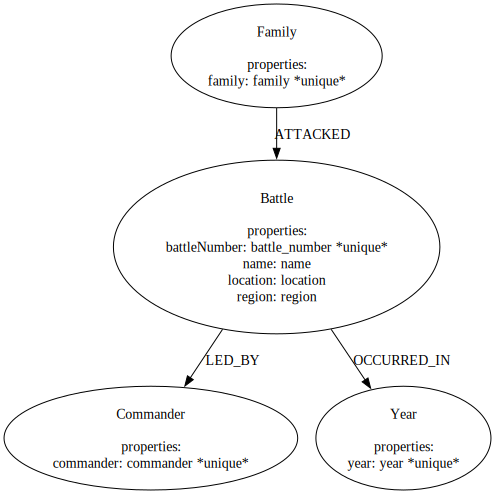

In [13]:
gdm.current_model.visualize()

### Making Corrections

In [14]:
corrections = """
1. Create separate nodes for location and region. 
2. Change ATTACKED to PARTICIPATED_IN. 
3. Give LED_BY and PARTICIPATED_IN relationships the attacking and outcome properties.
4. Create a King node"""
gdm.iterate_model(corrections=corrections, max_retries=3, allow_duplicate_properties=True)

> Generating Data Model...
Attempts | 2  
Recieved Valid Data Model
Nodes
* (:Battle)      * (:Family)
* (:Commander)   * (:Year)
* (:Location)    * (:Region)
* (:King)         

Relationships
* (:Family)-[:PARTICIPATED_IN]->(:Battle)   
* (:Battle)-[:LED_BY]->(:Commander)         
* (:Battle)-[:OCCURRED_IN]->(:Year)         
* (:Battle)-[:LOCATED_AT]->(:Location)      
* (:Location)-[:REGION_OF]->(:Region)       
* (:Battle)-[:RULED_BY]->(:King)            


DataModel(nodes=[Node(label='Battle', properties=[Property(name='battleNumber', type='int', column_mapping='battle_number', alias='battle_number', is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False)], source_name='got_battles.csv'), Node(label='Family', properties=[Property(name='family', type='str', column_mapping='family', alias=None, is_unique=True, part_of_key=False)], source_name='got_armies.csv'), Node(label='Commander', properties=[Property(name='commander', type='str', column_mapping='commander', alias=None, is_unique=True, part_of_key=False)], source_name='got_armies.csv'), Node(label='Year', properties=[Property(name='year', type='int', column_mapping='year', alias=None, is_unique=True, part_of_key=False)], source_name='got_battles.csv'), Node(label='Location', properties=[Property(name='location', type='str', column_mapping='location', alias=None, is_unique=True, part_of_key=False)], sou

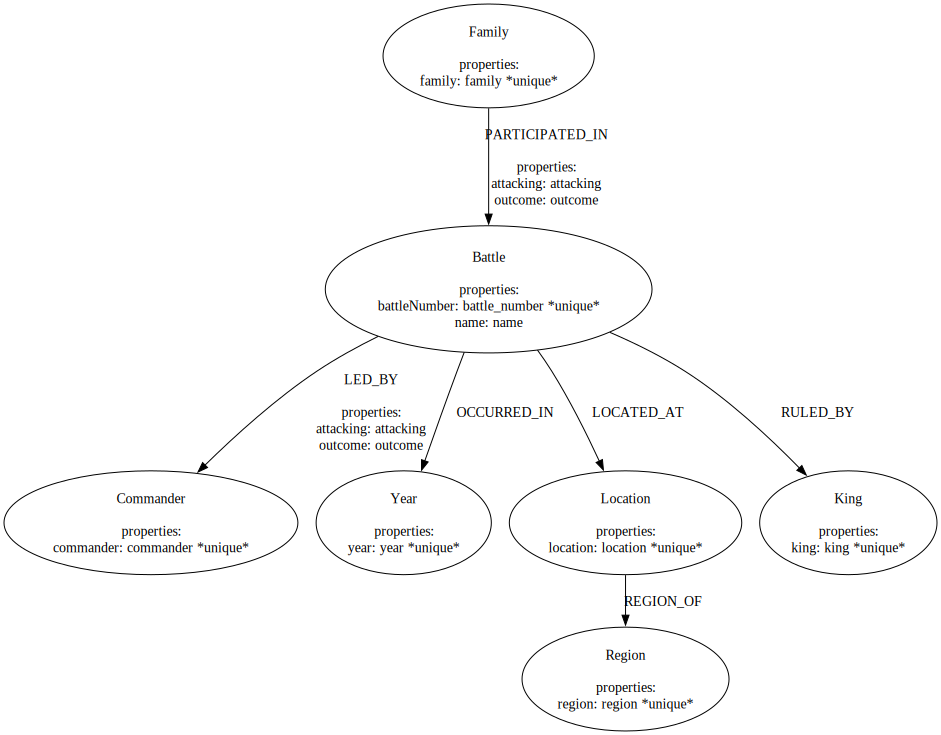

In [15]:
gdm.current_model.visualize()

In [16]:
corrections = """
1. Create a relationship between Family and King
2. Remove relationship between Battle and King"""
gdm.iterate_model(corrections=corrections, max_retries=3, allow_duplicate_properties=True)

> Generating Data Model...
Attempts | 3  
Recieved Valid Data Model
Nodes
* (:Battle)      * (:Family)
* (:Commander)   * (:Year)
* (:Location)    * (:Region)
* (:King)         

Relationships
* (:Family)-[:PARTICIPATED_IN]->(:Battle)   
* (:Battle)-[:LED_BY]->(:Commander)         
* (:Battle)-[:OCCURRED_IN]->(:Year)         
* (:Battle)-[:LOCATED_AT]->(:Location)      
* (:Location)-[:REGION_OF]->(:Region)       
* (:Family)-[:RULED_BY]->(:King)            


DataModel(nodes=[Node(label='Battle', properties=[Property(name='battleNumber', type='int', column_mapping='battle_number', alias='battle_number', is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False)], source_name='got_battles.csv'), Node(label='Family', properties=[Property(name='family', type='str', column_mapping='family', alias=None, is_unique=True, part_of_key=False)], source_name='got_armies.csv'), Node(label='Commander', properties=[Property(name='commander', type='str', column_mapping='commander', alias=None, is_unique=True, part_of_key=False)], source_name='got_armies.csv'), Node(label='Year', properties=[Property(name='year', type='int', column_mapping='year', alias=None, is_unique=True, part_of_key=False)], source_name='got_battles.csv'), Node(label='Location', properties=[Property(name='location', type='str', column_mapping='location', alias=None, is_unique=True, part_of_key=False)], sou

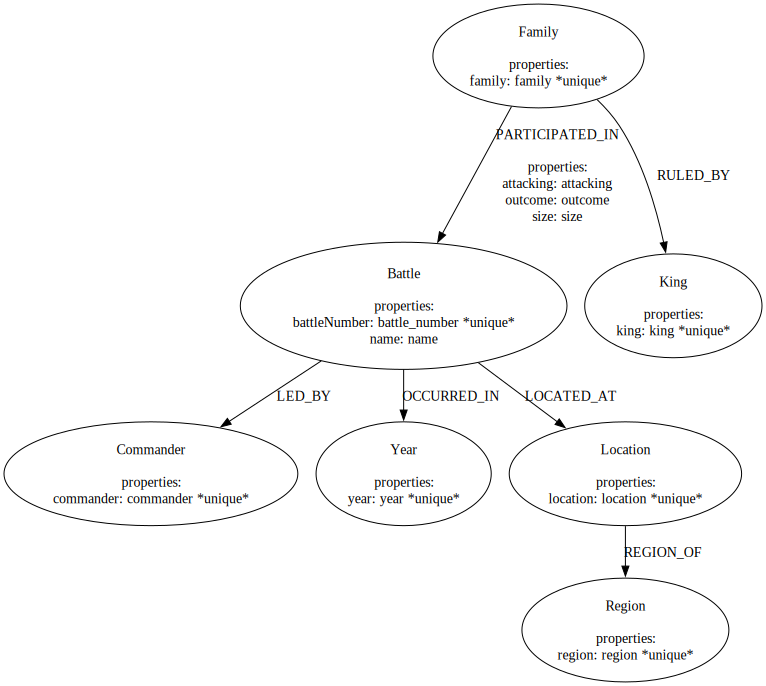

In [17]:
gdm.current_model.visualize()

## Code Generation

In [18]:
gen = PyIngestConfigGenerator(data_model=gdm.current_model, database="gameofthronesmulti", username="neo4j", uri=os.environ.get("NEO4J_URI"), password=os.environ.get("NEO4J_PASSWORD"), file_directory=data_directory)

Generating a file isn't necessary, but it's nice to have in case we want to reload data in the future.

In [19]:
gen.generate_config_yaml(file_name="./outputs/config.yaml")

## Ingest

In [20]:
PyIngest(config=gen.generate_config_string())